# QCM Noze. Методы обработки и анализа сигналов пъезоэлектрических датчиков для задачи определения наличия респираторных заболеваний.

В данной работе кратко описан принцип работы QCM-сенсоров и представлен набор базовых методов анализа данных в свете задачи распознавания больной особи крупного рогатого скота.

## Постановка задачи.

#### Задача
Задача состоит в принятии решения является ли особь здоровой по результатам проведенных с помощью QCM-носа замеров.<br>
Иными словами это задача бинарной классификации вида Болен-Здоров (0 и 1 соответственно) в основании которой лежит анализ сигналов, получаемых с датчиков.


#### Дано
1. [QCM-noze](https://www.researchgate.net/publication/341343073_Portable_E-nose_for_Diagnostic_of_Inflammation_and_Diverse_Variation_in_Health_Status_of_Humans_and_Animals) - Мультисенсорная система, состаящая из 8 кварцевых пластин (пъезоэлектрических датчиков); покрытия пластин из специального сольвента, обладающего повышенной сорбцией к ряду целевых веществ; газопроницаемой сетки в качестве дополнительного уровня фильтрации.
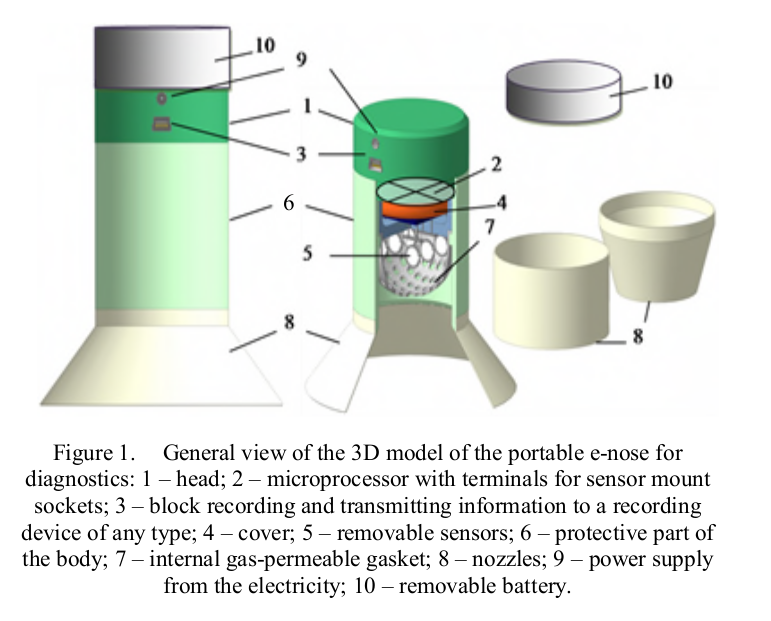
2. Данные о об изменении частоты резонаторов в течение так называемой стадии "вдоха" и стадии "выдоха"* с частотой измерений 1 раз в секунду. Вдох и выдох разделены друг от друга механическим воздействием на прибор, который порождает резкое изменение частот.
    * длительность стадии "вдоха" - 80 секунд(отсчетов)
    * длительность стадии "выдоха" - 120 секунд(отсчетов)
    
Данные сенсоров имеют следующий вид:

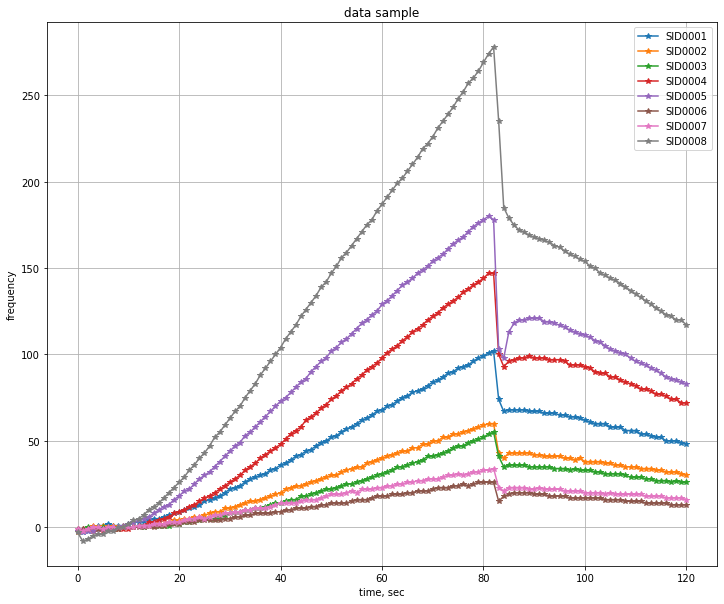

In [28]:
import os
from glob import glob

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# xls parser
def process_xls(xls_data):
    meta = xls_data.head(8)
    xls_data = xls_data[9:]

    meta.set_index('Название', inplace=True)
    meta = meta.transpose()
    meta.index = pd.RangeIndex(meta.shape[0])
    meta['Сенсоры'] = meta['Сенсоры'].apply(lambda x: x.split()[-1][1:-1])
    meta.set_index('Сенсоры', inplace=True)
    meta.dropna(how='all', axis=1, inplace=True)

    new_names = meta.index.values.tolist()
    new_names = ['time'] + new_names
    xls_data.columns = new_names
    xls_data.set_index('time', inplace=True)
    return meta, xls_data


# directory parser for xls search
def parse_dir(directory, desired_shape=(130, 9), ext='XLS'):
    def shape_check(t1, t2):
        return (t1[0] == t2[0]) and (t1[1] == t2[1])

    files = glob(os.path.join(directory, '*.' + ext))
    opened_files = list(map(pd.read_excel, files))
    file_shape_mask = list(map(lambda x: shape_check(x.shape, desired_shape), opened_files))
    opened_files = [fl for idx, fl in enumerate(opened_files) if file_shape_mask[idx]]
    processed_files = [process_xls(sensors_data) for sensors_data in opened_files]
    return processed_files


# function that transforms
# frequency change to mass change
def get_dm(df, base_f):
    calib_constant = 2.27 * 1e-06
    return (df * 0.2) / (calib_constant * base_f ** 2)

of = parse_dir('.')

data = [t[1].values.astype(int) for t in of]
labels = [0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]

# 3 is corrupted experiment
data.pop(3)
labels.pop(3)

dm_data = list()
for file_idx, xls_data in enumerate(data):
    sensors_base = of[file_idx][0]['Базовая частота']
    dm_data.append([get_dm(sensor_data, sensors_base[sensor_idx]) for sensor_idx, sensor_data in enumerate(xls_data.transpose())])


dm_data = list(map(np.stack, dm_data))
dm_data = list(map(np.transpose, dm_data))

plt.figure(figsize=(12, 10))
plt.plot(data[0], '-*')
plt.legend(of[0][1].columns.values)
plt.grid()
plt.title('data sample')
plt.ylabel('frequency')
plt.xlabel('time, sec')
plt.show()

Исходя из вида получаемых графиков (гладкие линии), а так же на основании схемы построения устройства не трудно заметить, что шумовая составляющая в данном сигнале минимальна и ей можно пренебречь.

## Предыдущий опыт решения задач
Классическим подходом для решения данной задачи является тест проверки гипотезы $H_0$ - особь здорова, против альтернативы $H_1$ - особь не здорова. Как правило используются тесты Неймана-Пирсона. 

Фактически задача сводится к поиску пороговых значений частот, начиная с которой особь считается больной и дальшейней агрегации решений с разных датчиков.

Пример схемы такой системы для двух-сенсорного устройства:
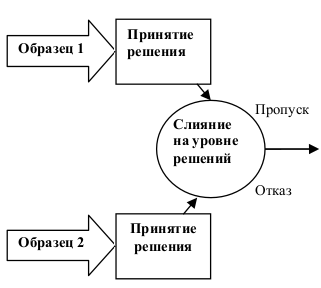

Подобные схемы подробно описаны в статье [Алгоритмы слияния данных в биометрических системах и применение в них нейросетевых технологий](https://elibrary.ru/item.asp?id=9312808)

При выборе констант следует учитывать принцип работы QCM-датчиков и прежде всего факт, о том, что это нановесы. Исходя из этого нетрудно сделать вывод о том, что у больной особи вес вещества (а значит и изменения частот от стандартных) скорее всего будет выше чем у здорового.

Для проверки этой гипотезы все имеющиеся данные по здоровым и больным особям были усреднены и подсчитана разница "средних" сигналов между больным и здоровым.

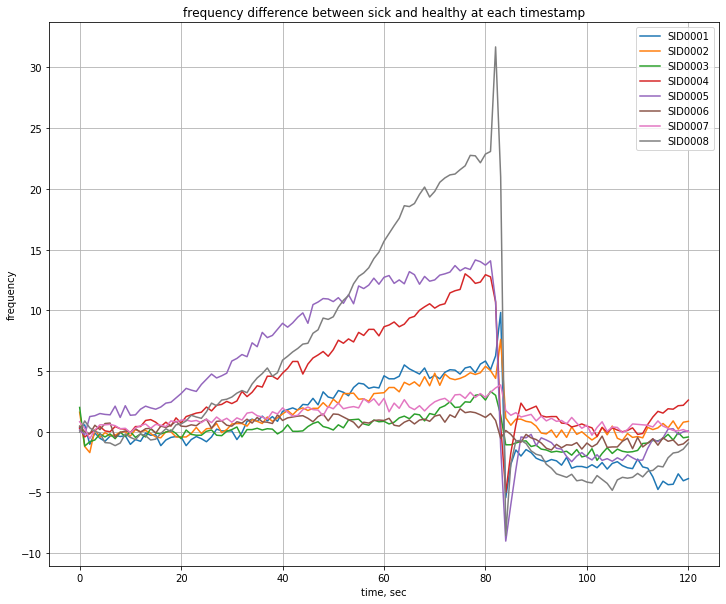

In [29]:
processed_data = list(map(lambda x: (x - x.mean(0) / x.std(0)), data))
health_means_processed_data = np.zeros((121, 8))
ill_means_processed_data = np.zeros((121, 8))
for i in range(len(labels)):
    if labels[i]:
        health_means_processed_data += processed_data[i].astype(int)
    else:
        ill_means_processed_data += processed_data[i].astype(int)
health_means_processed_data /= 4
ill_means_processed_data /= 7

plt.figure(figsize=(12, 10))
plt.plot(ill_means_processed_data - health_means_processed_data)
plt.legend(of[0][1].columns.values)
plt.grid()
plt.title('frequency difference between sick and healthy at each timestamp')
plt.ylabel('frequency')
plt.xlabel('time, sec')
plt.show()

Исходя из графика можно сделать вывод, что в среднем, начиная с некоторого момента времени t вес молекул на всех датчиках для больной особи больше чем для здоровой

## Предлогаемые подходы.

Для диагностирования наличия заболевания на основании  QCM-датчиков предлагается рассмотреть следующие методы:
1. Neural Network (Supervised approach) 
2. Space reduction + clusterisation (Unsupervised approach)

#### 1. Нейросети

На основе нейросетей можно выстроить 2 способа решения системы:
1. end-to-end - использовать сеть в качестве классификатора.
2. embeddings - использовть сеть в качестве преобразования данных сигнала в некоторое пространство, для последующей классификации. Предполагается что в этом пространстве больные и здоровые особи будут легко разделимы.

Тривиальный пример реализации подобной сети на  PyTorch:

В качестве входных данных для данной сети было использовано Z-преобразование "сырого" сигнала: 

$Z(X) = \frac{x_i - \mu(X)}{\sigma(X)}$,

где $\mu(x)$ - математическое ожидание сигнала; $\sigma(x)$ - стандартное отклонение Х

Пример тренировки:

In [19]:
class Simple1dConvNet(nn.Module):
    def __init__(self):
        super(Simple1dConvNet, self).__init__()
        convs = list()
        convs.append(nn.Conv1d(8, 4, 3, 1))
        convs.append(nn.Conv1d(4, 4, 3, 1))
        convs.append(nn.Conv1d(4, 2, 3, 1))
        convs.append(nn.Conv1d(2, 2, 3, 1))
        convs.append(nn.Conv1d(2, 1, 3, 1))
        self.extractor = nn.Sequential(*convs)
        self.classifier = nn.Linear(111, 2)

    def forward(self, x):
        x = self.extractor(x)
        x = torch.flatten(x)
        x = self.classifier(x)
        x = torch.sigmoid(x)
        return x


dnet = Simple1dConvNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(dnet.parameters(), lr=1e-5)
test_tensor = torch.from_numpy(dm_data[0].transpose().astype(float))
test_tensor = torch.unsqueeze(test_tensor, 0)
test_tensor = test_tensor.to(torch.float32)

for epoch in range(1000):
    for sample_idx, d_array in enumerate(data):
        processed = (d_array - d_array.mean(0) / d_array.std(0)).transpose()
        test_tensor = torch.from_numpy(processed)
        test_tensor = torch.unsqueeze(test_tensor, 0)
        test_tensor = test_tensor.to(torch.float32)
        output = dnet(test_tensor)
        label = torch.zeros(2)
        label[labels[sample_idx]] = 1
        loss = criterion(output, label)
        #         print(output, label)
        loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print('loss', loss)

        with torch.no_grad():
            predicts = list()
            for sample_idx, d_array in enumerate(data):
                processed = (d_array - d_array.mean(0) / d_array.std(0)).transpose()
                test_tensor = torch.from_numpy(processed)
                test_tensor = torch.unsqueeze(test_tensor, 0)
                test_tensor = test_tensor.to(torch.float32)
                output = dnet(test_tensor)
                predicts.append(output.argmax().item())
        print(predicts, labels)
        print(accuracy_score(predicts, labels))

loss tensor(0.7383, grad_fn=<BinaryCrossEntropyBackward>)
[1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1] [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
0.45454545454545453
loss tensor(0.5392, grad_fn=<BinaryCrossEntropyBackward>)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
0.6363636363636364
loss tensor(0.4188, grad_fn=<BinaryCrossEntropyBackward>)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
0.6363636363636364
loss tensor(0.2988, grad_fn=<BinaryCrossEntropyBackward>)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
0.6363636363636364
loss tensor(0.8119, grad_fn=<BinaryCrossEntropyBackward>)
[0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1] [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
0.7272727272727273
loss tensor(0.4990, grad_fn=<BinaryCrossEntropyBackward>)
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0] [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
0.8181818181818182
loss tensor(0.6231, grad_fn=<BinaryCrossEntropyBackward>)
[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0] [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
0.7

Как видно из примера подобная сеть способна к безошибочному отделению здоровых особей от больных. Но имеет место замечание о переобучении модели на скудном наборе данных.

Нейросетевой подход требует значительные объемы данных для настройки весов.

#### 2. Методы сокращения размерности.

Один из вариантов обработки и агрегации входных данных - их проекция в некоторое пространство.
В качестве такого преобразования рассмотрим [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

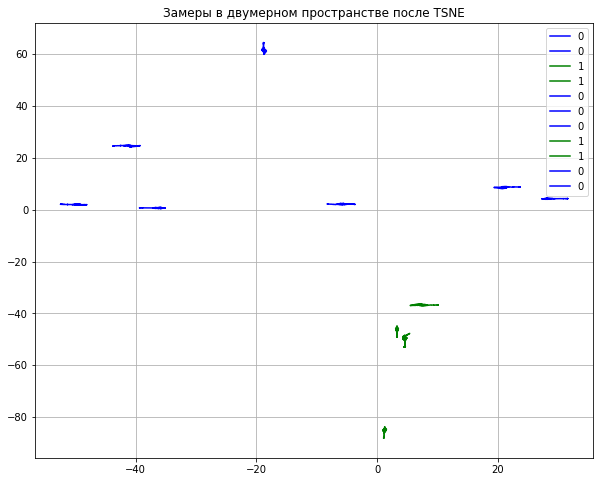

In [33]:
tsne = TSNE(n_components=2, perplexity=80, random_state=2, min_grad_norm=1e-7, angle=1)
tsne_data = list(map(tsne.fit_transform, data))
colors = ['b', 'g']
plt.figure(figsize=(10,8))
for i, d in enumerate(tsne_data):
    plt.plot(d[:,0], d[:,1], colors[labels[i]], label = labels[i])
plt.title('Замеры в двумерном пространстве после TSNE')
plt.legend()
plt.grid()
plt.show()

Нетрудно заметить, что в результате преобразования данные линейно разделимы.

In [36]:
clusterisator = KMeans(n_clusters=2, n_init=30, tol=1e-3)
pred = clusterisator.fit_predict(np.stack(tsne_data, 0).reshape(11, -1))

Так как изначально предполагалась кластеризация то, получим метки кластеров с помощью  Kmeans сравним классы с истиным разбиением:

In [37]:
print('Kmeans accuracy score', accuracy_score(labels, pred))

Kmeans accuracy score 1.0


In [16]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
